# imports

In [1]:
import os
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

sys.path.append("../")
from src.images.lowpass import GaussianBlurAll
from src.utils.image import imshow

%matplotlib inline

# arguments

In [2]:
#####
# TODO:
# set the path to ImageNet
imagenet_path = "/mnt/data/ImageNet/ILSVRC2012/"
#####

In [3]:
OUT_DIR = "./results"
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

In [4]:
# data settings
batch_size = 4
workers = 4
distributed = False
train_sampler = None

# random seed settings
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

In [5]:
# settings for blur
sigma = 5
radius = sigma * 3 * 2 + 1
kernel_size = (radius, radius)  # It's also okay to set (0,0) as kernel_size.

# load dataset (ImageNet)

In [6]:
traindir = os.path.join(imagenet_path, "train")
valdir = os.path.join(imagenet_path, "val")

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose(
        [
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]
    ),
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=(train_sampler is None),
    num_workers=workers,
    pin_memory=True,
    sampler=train_sampler,
)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(
        valdir,
        transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ]
        ),
    ),
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    pin_memory=True,
)

In [7]:
dataiter = iter(train_loader)
images, target = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([161, 945, 931, 832])


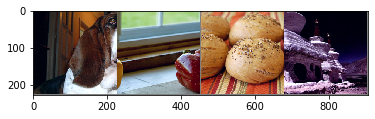

In [8]:
# show images
print(target)
imshow(torchvision.utils.make_grid(images))

In [9]:
images.size()

torch.Size([4, 3, 224, 224])

# blur images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


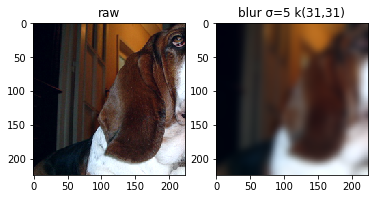

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


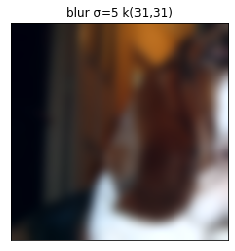

In [10]:
blur_file = os.path.join(
    OUT_DIR, "blur_s{0}_k{1}-{1}.png".format(sigma, kernel_size[0])
)
comp_file = os.path.join(
    OUT_DIR, "blur_s{0}_k{1}-{1}_comparison.png".format(sigma, kernel_size[0])
)

img = images[0]
img = img / 4 + 0.5
npimg = img.numpy()
blur = cv2.GaussianBlur(npimg.transpose(1, 2, 0), kernel_size, sigma)
# cv2.imwrite('./blur_s3_k9-9.png', blur)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(npimg.transpose(1, 2, 0))
axes[0].set_title("raw")
axes[1].imshow(blur)
axes[1].set_title("blur σ={0} k({1},{1})".format(sigma, kernel_size[0]))
# axes[1].set_title('blur k({0},{0})'.format(kernel_size[0]))
# axes[1].set_title('blur σ={0}'.format(sigma))
plt.savefig(comp_file)
plt.show(fig)
# show and save an image
# plt.figure(figsize=(32,32))
# plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
fig, axes = plt.subplots(1, 1)
plt.xticks([])
plt.yticks([])
axes.set_title("blur σ={0} k({1},{1})".format(sigma, kernel_size[0]))
plt.imshow(blur)
plt.savefig(blur_file)  # added for saving the image
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


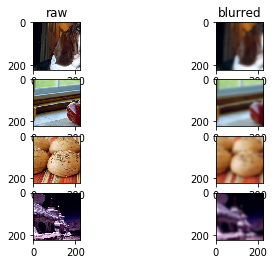

In [11]:
blurred = GaussianBlurAll(images, sigma=sigma)

raw = images.numpy()
blurred = blurred.numpy()

# unnormalize
raw = raw / 4 + 0.5
blurred = blurred / 4 + 0.5

num = raw.shape[0]  # number of images
fig, axes = plt.subplots(num, 2)
axes[0][0].set_title("raw")
axes[0][1].set_title("blurred")
for i in range(num):
    axes[i][0].imshow(raw[i].transpose(1, 2, 0))
    axes[i][1].imshow(blurred[i].transpose(1, 2, 0))
plt.show(fig)